# Dataset download
In this section the dataset is downloaded from *Kaggle*, unzipped and well formatted.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
! pip install -q kaggle

from google.colab import files
_ = files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d ikarus777/best-artworks-of-all-time
! unzip best-artworks-of-all-time.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflati

#Data preprocessing

In [ ]:
artists = pd.read_csv('artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
#artists_top = artists_top.loc[artists_top['paintings'] >200]
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [ ]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

Next step is to solve a problem: the downloaded dataset present two directory containing the same paintings but they have different name. What we do in the next cells is to create a single directory called 'Albrecht_Durer' containing one copy of each painting, and then we delete all unuseful directories.

In [ ]:
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name
images_dir = 'images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
! mv '/content/images/images/Albrecht_Du╠Иrer' /content/images/images/Albrecht_Dürer

In [ ]:
! rm -R '/content/images/images/Albrecht_DuтХа├кrer' 
! rm -R '/content/resized'

#Data fetch

In [ ]:
import pathlib
import os

IMAGE_DIR = '/content/images/'
TRAIN_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'train'))
TEST_DIR = pathlib.Path(os.path.join(IMAGE_DIR, 'test'))

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 128
RANDOM_SEED = 42
VALIDATION_SPLIT = 0.10

In [ ]:
import os
import numpy as np
import shutil

rootdir= '/content/images/images' #path of the original folder
classes = os.listdir(rootdir)

for i, c in enumerate(classes, start=1):
  if c not in artists_top_name.tolist():
    shutil.rmtree(rootdir + '/' + c)
    continue
  if not os.path.exists(rootdir + '/train/' + c):
    os.makedirs(rootdir + '/train/' + c)
  if not os.path.exists(rootdir + '/test/' + c):  
    os.makedirs(rootdir + '/test/' + c)

  source = os.path.join(rootdir, c)
  allFileNames = os.listdir(source)

  np.random.shuffle(allFileNames)

  test_ratio = 0.10
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + c)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + c)

In [ ]:
! mv /content/images/images/train /content/images
! mv /content/images/images/test /content/images
! rm -r /content/images/images

In [ ]:
import tensorflow as tf

training_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='training',
    interpolation='bilinear', follow_links=False
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, validation_split=VALIDATION_SPLIT, subset='validation',
    interpolation='bilinear', follow_links=False
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=(IMAGE_HEIGHT,
    IMAGE_WIDTH), shuffle=True, seed=RANDOM_SEED, interpolation='bilinear', follow_links=False
)


Found 3864 files belonging to 11 classes.
Using 3478 files for training.
Found 3864 files belonging to 11 classes.
Using 386 files for validation.
Found 435 files belonging to 11 classes.


In [ ]:
NUM_CLASSES = len(training_images.class_names)

#Build model

Needed imports:

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

Callback and data augmentation objects:

In [ ]:
callbacks_list = [
    ks.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
    ),
    ks.callbacks.ModelCheckpoint(
        filepath='checkpoint_vgg16.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]
data_augmentation = ks.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1)
    ]
)

##### ResNet50 class:

In [ ]:
class ResNet50:
    LOSS = 'categorical_crossentropy'

    def __init__(self, train=None, test=None, val=None, classes=11, epochs=10,
                 callbacks_list=None, data_augmentation=None, class_weights=None):
        # set datasets
        self.training_set = train
        self.test_set = test
        self.val_set = val

        # model
        self.model = None

        # utils
        self.history = None
        self.classes = classes
        self.epochs = epochs
        self.callbacks_list = callbacks_list
        self.data_augmentation = data_augmentation
        self.class_weights = class_weights

    """
        ARCHITECTURE TO TEST
    """

    def classic_resnet50(self):
        inputs = self.input()
        x = self.base_resnet50v2()(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet50_finetuned(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet50_finetuned_dense(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense1')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense2')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    def resnet50_finetuned_2drop_dense(self, num_of_blocks=1):
        inputs = self.input()
        x = self.fine_tuning(num_of_blocks=num_of_blocks)(inputs)
        x = layers.GlobalAveragePooling2D(name='my_glo_avg_pool')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense1')(x)
        x = layers.Dense(256,
                         activation='relu',
                         name='my_dense2')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(self.classes, activation='softmax', name='predictions')(x)
        self.model = ks.Model(inputs=inputs, outputs=outputs)

    """
            NETWORK PIECE BY PIECE STRUCTURE BLOCK
    """

    def input(self):
        inputs = ks.Input(shape=(224, 224, 3))
        x = ks.applications.resnet50.preprocess_input(inputs)
        x = self.data_augmentation(x)
        x = layers.Rescaling(1. / 255)(x)
        return x

    def base_resnet50v2(self):
        res = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=((224, 224, 3))
        )
        res.trainable = False
        return res

    def fine_tuning(self, num_of_blocks=1):
        if num_of_blocks < 1:
            num_of_blocks = 1

        res = self.base_resnet50v2()
        res.trainable = True
        set_trainable = False

        if num_of_blocks == 1:
            block_name = 'conv5_block2_out'
        else:
            block_name = 'conv5_block1_out'

        for layer in res.layers:
            if layer.name == block_name:
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        return res

    """
            UTILITIES
    """

    def plot_model(self, model_name):
        ks.utils.plot_model(self.model, model_name, show_shapes=True)

    def plot_accuracy(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        plt.plot(range(1, len(acc) + 1), acc, 'r', label='Training Accuracy')
        plt.plot(range(1, len(acc) + 1), val_acc, 'g', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.plot()

    def plot_loss(self):
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        plt.plot(range(1, len(loss) + 1), loss, 'r', label='Training Loss')
        plt.plot(range(1, len(loss) + 1), val_loss, 'g', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.plot()

    def summary(self):
        self.model.summary()

    """
          COMPILE AND FIT
    """

    def compile_and_fit(self, optimizer):
        self.model.compile(
            optimizer=optimizer,
            loss=self.LOSS,
            metrics=['accuracy']
        )

        if self.callbacks_list is None:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set
            )
        else:
            self.history = self.model.fit(
                self.training_set,
                epochs=self.epochs,
                validation_data=self.val_set,
                callbacks=self.callbacks_list,
                class_weight=self.class_weights
            )

    def evaluate(self):
        test_loss, test_acc = self.model.evaluate(self.test_set)
        print(f"Test accuracy: {test_acc:.3f}")

#### Feature extraction:

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.classic_resnet50()
resnet50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 23,587,339
Trainable params: 22,539
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 124.2826 - accuracy: 0.0811

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 51s 1s/step - loss: 124.2826 - accuracy: 0.0811 - val_loss: 57.5021 - val_accuracy: 0.1399
Epoch 2/60
28/28 [==============================] - 33s 972ms/step - loss: 48.3195 - accuracy: 0.1133 - val_loss: 33.4855 - val_accuracy: 0.1244
Epoch 3/60
28/28 [==============================] - 35s 1s/step - loss: 32.9070 - accuracy: 0.1357 - val_loss: 24.9883 - val_accuracy: 0.1528
Epoch 4/60
28/28 [==============================] - 33s 971ms/step - loss: 26.0092 - accuracy: 0.1636 - val_loss: 20.4153 - val_accuracy: 0.1891
Epoch 5/60
28/28 [==============================] - 33s 969ms/step - loss: 22.1266 - accuracy: 0.1866 - val_loss: 17.9532 - val_accuracy: 0.2306
Epoch 6/60
28/28 [==============================] - 33s 968ms/step - loss: 19.6157 - accuracy: 0.2039 - val_loss: 15.9380 - val_accuracy: 0.2435
Epoch 7/60
28/28 [==============================] - 38s 1s/step - loss: 17.7850 - accuracy: 0.2122 - val_loss: 14.6244 - val_accuracy: 0.2720
Epoc

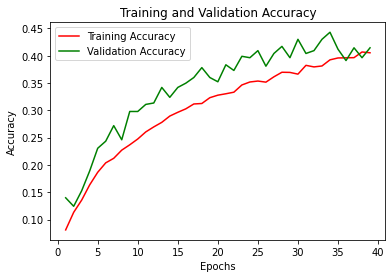

In [ ]:
resnet50.plot_accuracy()

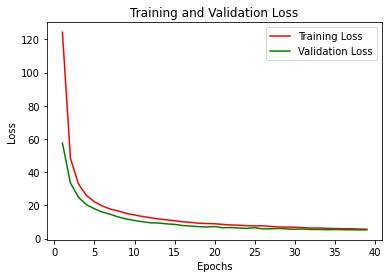

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 9s 1s/step - loss: 6.8513 - accuracy: 0.3241
Test accuracy: 0.324


## Fine tuning one block

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.resnet50_finetuned(num_of_blocks=1)
resnet50.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 23,587,339
Trainable params: 4,491,275
Non-trainable params: 19,096,064
_________________________________________________________________


In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 2.3591 - accuracy: 0.2694

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 59s 1s/step - loss: 2.3591 - accuracy: 0.2694 - val_loss: 33.0204 - val_accuracy: 0.0777
Epoch 2/60
28/28 [==============================] - 41s 1s/step - loss: 1.8877 - accuracy: 0.4028 - val_loss: 31.8137 - val_accuracy: 0.0803
Epoch 3/60
28/28 [==============================] - 41s 1s/step - loss: 1.6658 - accuracy: 0.4980 - val_loss: 6.3626 - val_accuracy: 0.1891
Epoch 4/60
28/28 [==============================] - 41s 1s/step - loss: 1.4689 - accuracy: 0.5618 - val_loss: 3.2371 - val_accuracy: 0.3031
Epoch 5/60
28/28 [==============================] - 37s 1s/step - loss: 1.3047 - accuracy: 0.6156 - val_loss: 2.0193 - val_accuracy: 0.4093
Epoch 6/60
28/28 [==============================] - 37s 1s/step - loss: 1.1478 - accuracy: 0.6564 - val_loss: 1.5889 - val_accuracy: 0.4534
Epoch 7/60
28/28 [==============================] - 37s 1s/step - loss: 0.9947 - accuracy: 0.7039 - val_loss: 1.3356 - val_accuracy: 0.5466
Epoch 8/60
28/28 [===========

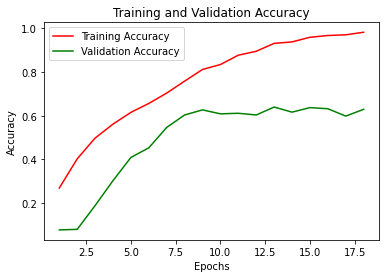

In [ ]:
resnet50.plot_accuracy()

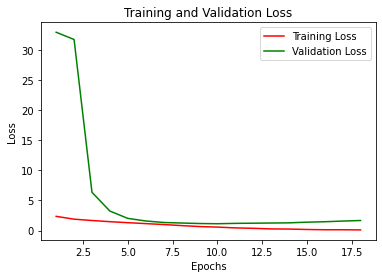

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 10s 2s/step - loss: 1.7916 - accuracy: 0.5793
Test accuracy: 0.579


### Finetuned 2 blocks

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.resnet50_finetuned(num_of_blocks=2)
resnet50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 predictions (Dense)         (None, 11)                22539     
                                                                 
Total params: 23,587,339
Trainable params: 8,955,915
Non-trainable params: 14,631,424
_________________________________________________________________


In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 43s 1s/step - loss: 2.1908 - accuracy: 0.3051 - val_loss: 55.2660 - val_accuracy: 0.1036
Epoch 2/60
28/28 [==============================] - 38s 1s/step - loss: 1.6789 - accuracy: 0.4896 - val_loss: 8.3807 - val_accuracy: 0.2124
Epoch 3/60
28/28 [==============================] - 41s 1s/step - loss: 1.4448 - accuracy: 0.5673 - val_loss: 3.1678 - val_accuracy: 0.3420
Epoch 4/60
28/28 [==============================] - 45s 1s/step - loss: 1.2026 - accuracy: 0.6466 - val_loss: 3.4512 - val_accuracy: 0.3446
Epoch 5/60
28/28 [==============================] - 39s 1s/step - loss: 0.9619 - accuracy: 0.7154 - val_loss: 3.0062 - val_accuracy: 0.3860
Epoch 6/60
28/28 [==============================] - 39s 1s/step - loss: 0.7501 - accuracy: 0.7855 - val_loss: 1.7016 - val_accuracy: 0.5233
Epoch 7/60
28/28 [==============================] - 38s 1s/step - loss: 0.5249 - accuracy: 0.8522 - val_loss: 1.7218 - val_accuracy: 0.5130
Epoch 8/60
28/28 [=

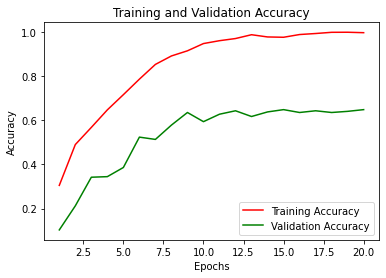

In [ ]:
resnet50.plot_accuracy()

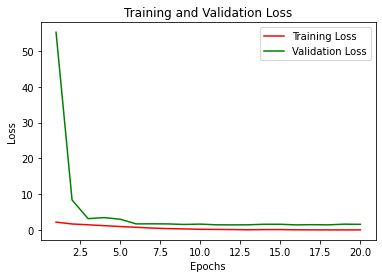

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 5s 687ms/step - loss: 1.7734 - accuracy: 0.6092
Test accuracy: 0.609


#### Fine tuned + Denses

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.resnet50_finetuned_dense(num_of_blocks=2)
resnet50.summary()

94683136/94668760 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 my_dense1 (Dense)           (None, 256)               524544    
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0      

In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.0001))

Epoch 1/60
28/28 [==============================] - ETA: 0s - loss: 36.7419 - accuracy: 0.1843

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 66s 2s/step - loss: 36.7419 - accuracy: 0.1843 - val_loss: 37.5593 - val_accuracy: 0.1425
Epoch 2/60
28/28 [==============================] - 36s 1s/step - loss: 33.8576 - accuracy: 0.2685 - val_loss: 33.6128 - val_accuracy: 0.1606
Epoch 3/60
28/28 [==============================] - 36s 1s/step - loss: 31.1513 - accuracy: 0.2967 - val_loss: 30.4299 - val_accuracy: 0.1969
Epoch 4/60
28/28 [==============================] - 36s 1s/step - loss: 28.6048 - accuracy: 0.3243 - val_loss: 27.4383 - val_accuracy: 0.2539
Epoch 5/60
28/28 [==============================] - 39s 1s/step - loss: 26.2220 - accuracy: 0.3485 - val_loss: 24.9245 - val_accuracy: 0.3187
Epoch 6/60
28/28 [==============================] - 39s 1s/step - loss: 23.9889 - accuracy: 0.3795 - val_loss: 22.7313 - val_accuracy: 0.3368
Epoch 7/60
28/28 [==============================] - 36s 1s/step - loss: 21.9139 - accuracy: 0.3930 - val_loss: 20.6567 - val_accuracy: 0.3912
Epoch 8/60
28/28 

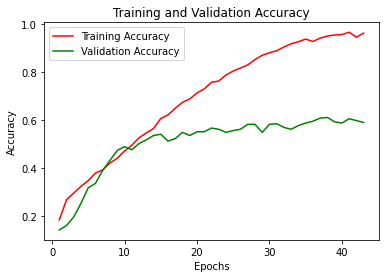

In [ ]:
resnet50.plot_accuracy()

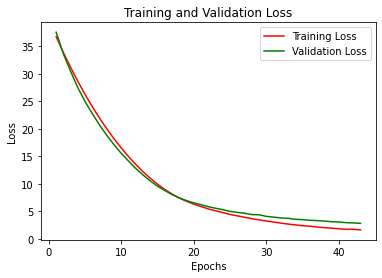

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 10s 1s/step - loss: 2.8338 - accuracy: 0.5977
Test accuracy: 0.598


### Fine tuned 1 + dense

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.resnet50_finetuned_dense(num_of_blocks=1)
resnet50.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 my_dense1 (Dense)           (None, 256)               524544    
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 39s 1s/step - loss: 2.3727 - accuracy: 0.2657 - val_loss: 11.8658 - val_accuracy: 0.0829
Epoch 2/60
28/28 [==============================] - 34s 997ms/step - loss: 1.9697 - accuracy: 0.3841 - val_loss: 7.5842 - val_accuracy: 0.1632
Epoch 3/60
28/28 [==============================] - 37s 1s/step - loss: 1.7699 - accuracy: 0.4534 - val_loss: 3.4738 - val_accuracy: 0.2228
Epoch 4/60
28/28 [==============================] - 34s 996ms/step - loss: 1.6257 - accuracy: 0.5135 - val_loss: 2.8819 - val_accuracy: 0.2746
Epoch 5/60
28/28 [==============================] - 34s 992ms/step - loss: 1.4942 - accuracy: 0.5635 - val_loss: 2.1099 - val_accuracy: 0.3446
Epoch 6/60
28/28 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.6162

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


28/28 [==============================] - 35s 1s/step - loss: 1.3033 - accuracy: 0.6162 - val_loss: 1.9066 - val_accuracy: 0.4275
Epoch 7/60
28/28 [==============================] - 35s 1s/step - loss: 1.2001 - accuracy: 0.6377 - val_loss: 1.7272 - val_accuracy: 0.4741
Epoch 8/60
28/28 [==============================] - 39s 1s/step - loss: 1.0575 - accuracy: 0.6941 - val_loss: 1.2440 - val_accuracy: 0.5751
Epoch 9/60
28/28 [==============================] - 38s 1s/step - loss: 0.9451 - accuracy: 0.7194 - val_loss: 1.3999 - val_accuracy: 0.5622
Epoch 10/60
28/28 [==============================] - 39s 1s/step - loss: 0.8129 - accuracy: 0.7614 - val_loss: 1.2255 - val_accuracy: 0.6321
Epoch 11/60
28/28 [==============================] - 34s 976ms/step - loss: 0.7354 - accuracy: 0.7780 - val_loss: 1.2694 - val_accuracy: 0.6269
Epoch 12/60
28/28 [==============================] - 34s 980ms/step - loss: 0.6034 - accuracy: 0.8177 - val_loss: 1.2436 - val_accuracy: 0.6399
Epoch 13/60
28/28 [===

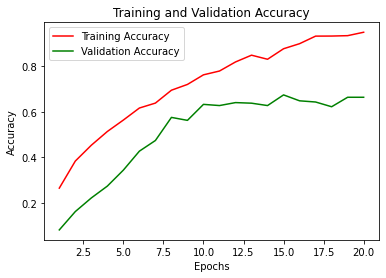

In [ ]:
resnet50.plot_accuracy()

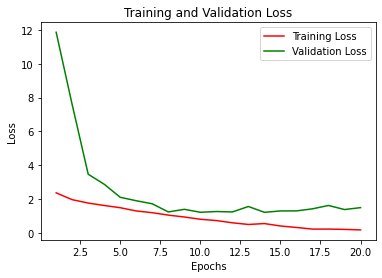

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 5s 551ms/step - loss: 1.6655 - accuracy: 0.6368
Test accuracy: 0.637


### Finetune 2 + dense

In [ ]:
resnet50 = ResNet50(train=training_images, val=val_images, test=test_images, 
              classes=NUM_CLASSES, callbacks_list=callbacks_list, 
              data_augmentation=data_augmentation, class_weights=class_weights,
              epochs=60)
resnet50.resnet50_finetuned_dense(num_of_blocks=2)
resnet50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 my_glo_avg_pool (GlobalAver  (None, 2048)             0         
 agePooling2D)                                                   
                                                                 
 my_dense1 (Dense)           (None, 256)               524544    
                                                                 
 my_dense2 (Dense)           (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
resnet50.compile_and_fit(optimizer=ks.optimizers.Adam(learning_rate=0.001))

Epoch 1/60
28/28 [==============================] - 41s 1s/step - loss: 2.3128 - accuracy: 0.2881 - val_loss: 27.4279 - val_accuracy: 0.0648
Epoch 2/60
28/28 [==============================] - 35s 1s/step - loss: 1.8975 - accuracy: 0.4186 - val_loss: 8.9868 - val_accuracy: 0.1736
Epoch 3/60
28/28 [==============================] - 36s 1s/step - loss: 1.6648 - accuracy: 0.5020 - val_loss: 11.1082 - val_accuracy: 0.1943
Epoch 4/60
28/28 [==============================] - 35s 1s/step - loss: 1.4183 - accuracy: 0.5736 - val_loss: 3.3385 - val_accuracy: 0.2358
Epoch 5/60
28/28 [==============================] - 35s 1s/step - loss: 1.2217 - accuracy: 0.6323 - val_loss: 3.5446 - val_accuracy: 0.2979
Epoch 6/60
28/28 [==============================] - 35s 1s/step - loss: 1.0049 - accuracy: 0.6998 - val_loss: 1.9976 - val_accuracy: 0.4819
Epoch 7/60
28/28 [==============================] - 35s 1s/step - loss: 0.8398 - accuracy: 0.7392 - val_loss: 1.7911 - val_accuracy: 0.4637
Epoch 8/60
28/28 [

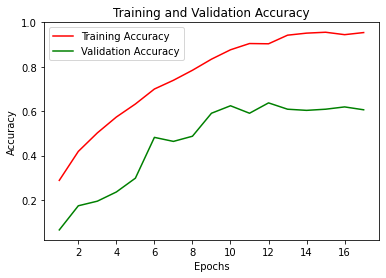

In [ ]:
resnet50.plot_accuracy()

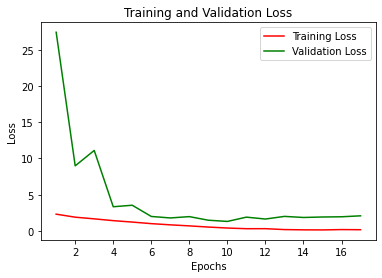

In [ ]:
resnet50.plot_loss()

In [ ]:
resnet50.evaluate()

4/4 [==============================] - 6s 578ms/step - loss: 2.1089 - accuracy: 0.5954
Test accuracy: 0.595
